In [1]:
import os
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm

from utils import format_image_id, parse_annotations, plot_image, get_box
from config import IMAGE_PATH, ANNOTATION_PATH
from config import KEY_POINT_LABELS_ALL, MISSING_IMAGES, MAX_IMAGE_ID, IMAGE_SIZE

# Plotting a few images from our dataset

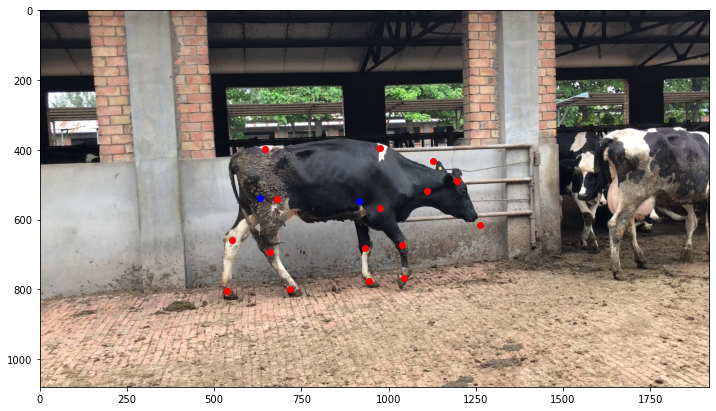

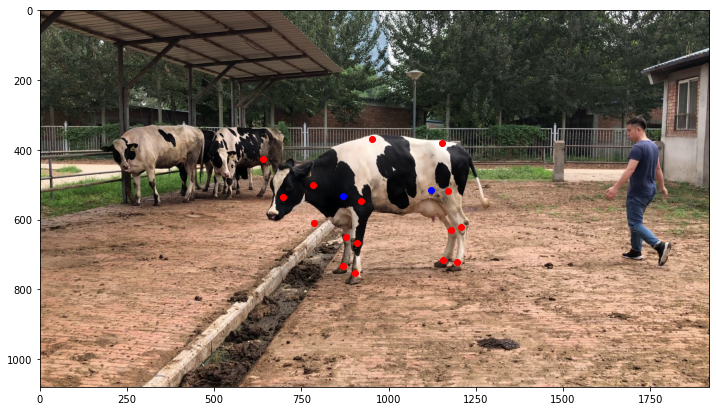

In [2]:
for i in range(1, 3):
    plot_image(format_image_id(i), plot_points = True)

# Limitations of Data

> The provided data only have key-points for one central cow, while some images have many cows

> this creates hurdles for model to learn effectively


#### Solution

- we can incorporate multistage process 1) detect cows 2) crop detected cow from image 3) run key-poit detection over teh cropped segment of image
- We can use pretrained Object detection Model trained on COCO (which already has cow as category)
- We can train key-point detection model using provided data and infer that model on cropped cow images from 1st stage

# Some Statistics

Number of Images

In [3]:
len(os.listdir(IMAGE_PATH))

2134

>Images are only 2134 while image id varies from 1 to 2213 -> so 79 image_ids are missing

- let's find out which one are missing
- lets also verify the annotations exists as well

In [4]:
missing_images = []
for i in range(1, MAX_IMAGE_ID+1):
    if not os.path.exists(os.path.join(IMAGE_PATH, format_image_id(i)+'.jpg')):
        missing_images.append(i)
    else:
        # So image exists, 
        assert os.path.exists(os.path.join(ANNOTATION_PATH, format_image_id(i)+'.txt'))
assert len(os.listdir(IMAGE_PATH)) == len(os.listdir(ANNOTATION_PATH)) 
print('This all image ids are missing from dataset -> {}'.format(missing_images))

This all image ids are missing from dataset -> [107, 137, 147, 205, 222, 275, 337, 363, 369, 370, 372, 448, 456, 460, 479, 490, 495, 516, 560, 575, 597, 643, 676, 703, 749, 770, 781, 854, 876, 904, 929, 963, 984, 989, 1014, 1041, 1066, 1167, 1282, 1289, 1347, 1379, 1406, 1410, 1431, 1432, 1448, 1449, 1460, 1468, 1504, 1512, 1516, 1519, 1532, 1550, 1564, 1592, 1594, 1612, 1639, 1662, 1673, 1696, 1706, 1710, 1735, 1746, 1750, 1753, 1758, 1776, 1777, 1793, 1844, 1855, 1864, 1900, 1937]


Image size and whether all image sizes are equal

In [5]:
image_1 = cv2.imread(os.path.join(IMAGE_PATH, format_image_id(1) + '.jpg'))
print('Image shape is {}'.format(image_1.shape))

for i in tqdm(range(2, MAX_IMAGE_ID+1)):
    # skip the missing images
    if i not in MISSING_IMAGES:
        image_i = cv2.imread(os.path.join(IMAGE_PATH, format_image_id(i) + '.jpg'))
        assert image_1.shape == image_i.shape

Image shape is (1080, 1920, 3)


100%|██████████████████████████████████████████████████████████████████████████████| 2212/2212 [01:34<00:00, 23.47it/s]


Lets verify there are equal number of key-points on every annotation_file

In [6]:
annot_1 = parse_annotations(os.path.join(ANNOTATION_PATH, format_image_id(1)+'.txt'))
print('Annotation shape is {}'.format(annot_1.shape))

for i in tqdm(range(2, MAX_IMAGE_ID+1)):
    if i not in MISSING_IMAGES:
        annot_i = parse_annotations(os.path.join(ANNOTATION_PATH, format_image_id(i)+'.txt'))
        assert annot_1.shape == annot_i.shape

Annotation shape is (18, 3)


100%|████████████████████████████████████████████████████████████████████████████| 2212/2212 [00:00<00:00, 5820.67it/s]


# Keypoints Labeling

> There are 18 key-points on all images, looking at a few images we can label them

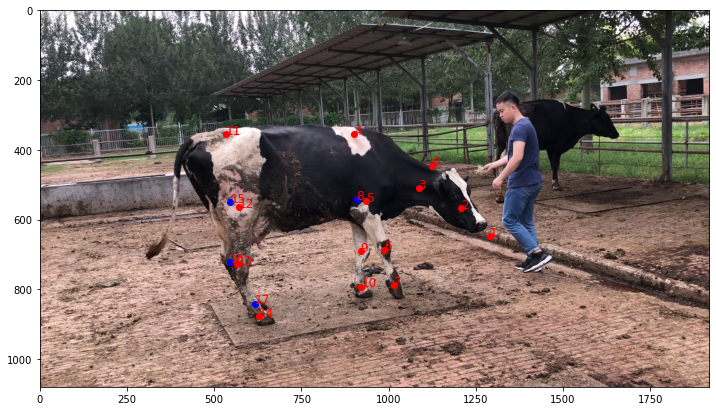

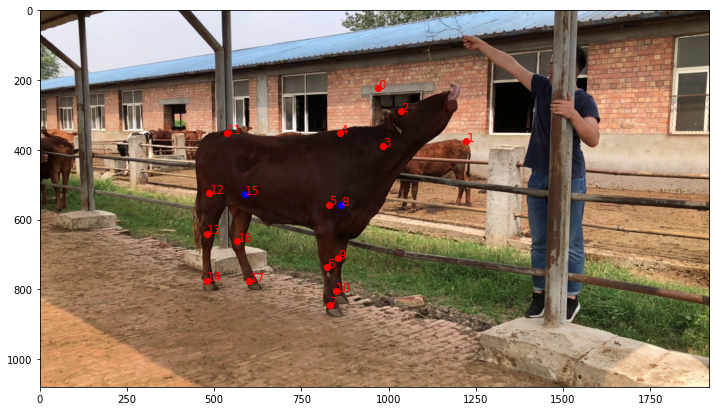

Assigned Label for point 0 is head_top
Assigned Label for point 1 is head_bottom
Assigned Label for point 2 is face
Assigned Label for point 3 is neck
Assigned Label for point 4 is upper_back
Assigned Label for point 5 is front_right_leg_top
Assigned Label for point 6 is front_right_leg_center
Assigned Label for point 7 is front_right_leg_bottom
Assigned Label for point 8 is front_left_leg_top
Assigned Label for point 9 is front_left_leg_center
Assigned Label for point 10 is front_left_leg_bottom
Assigned Label for point 11 is lower_back
Assigned Label for point 12 is rear_right_leg_top
Assigned Label for point 13 is rear_right_leg_center
Assigned Label for point 14 is rear_right_leg_bottom
Assigned Label for point 15 is rear_left_leg_top
Assigned Label for point 16 is rear_left_leg_center
Assigned Label for point 17 is rear_left_leg_bottom


In [2]:
for i in range(8, 10):
    plot_image(format_image_id(i), plot_points = True, plot_labels=True)
    
for i, point_label in enumerate(KEY_POINT_LABELS_ALL):
    print('Assigned Label for point {} is {}'.format(i, point_label))

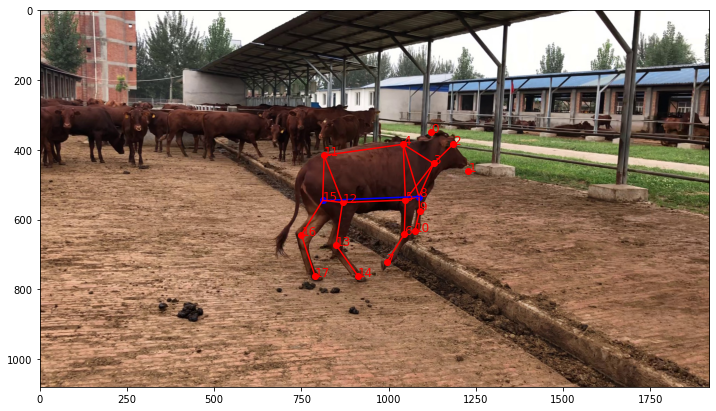

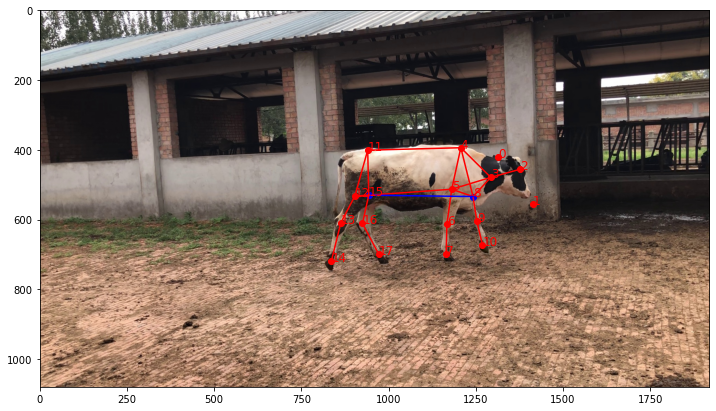

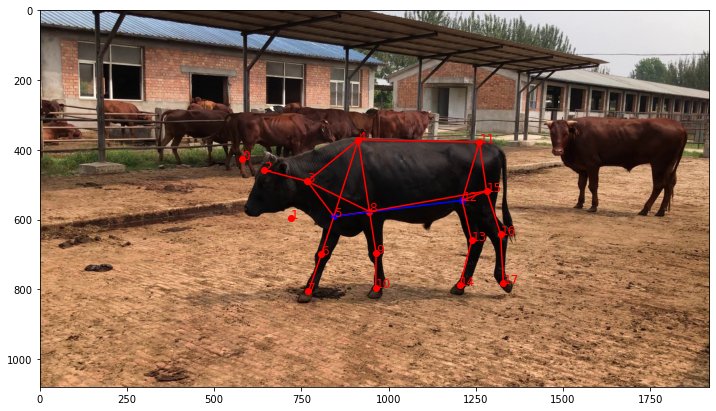

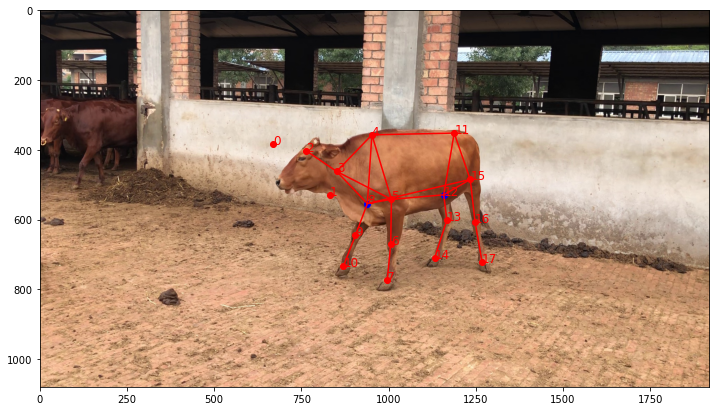

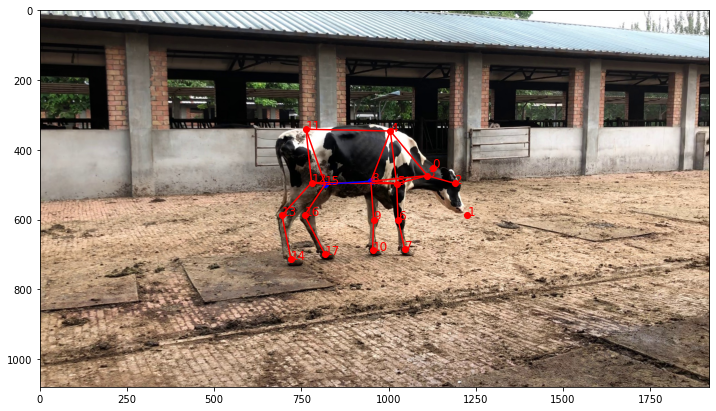

In [3]:
for i in range(18, 23):
    plot_image(format_image_id(i), plot_points = True, 
               plot_labels=True, plot_lines = True)


# Derivation of Bouding box from key-points

We can derive approximate abounding boxes from given key-point coordinates

Limitation is that, there are key-points provided only for one cow per image so we can only get approximate bounding box for one of the cow

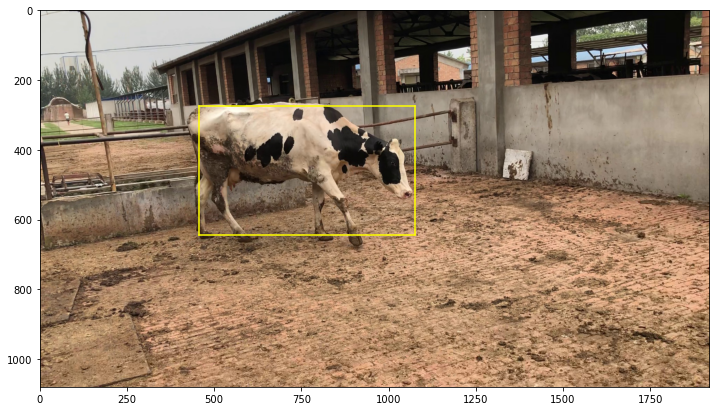

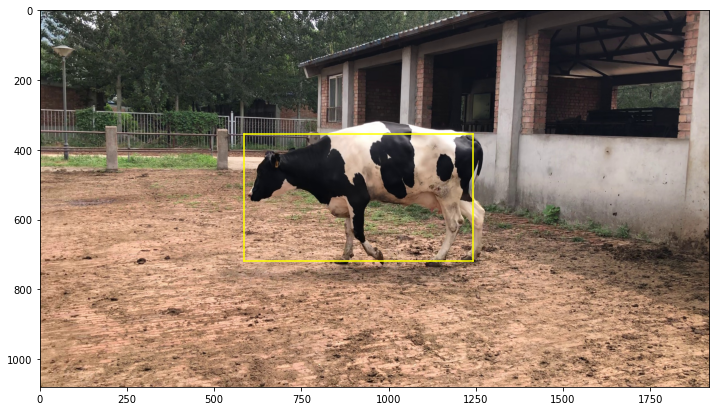

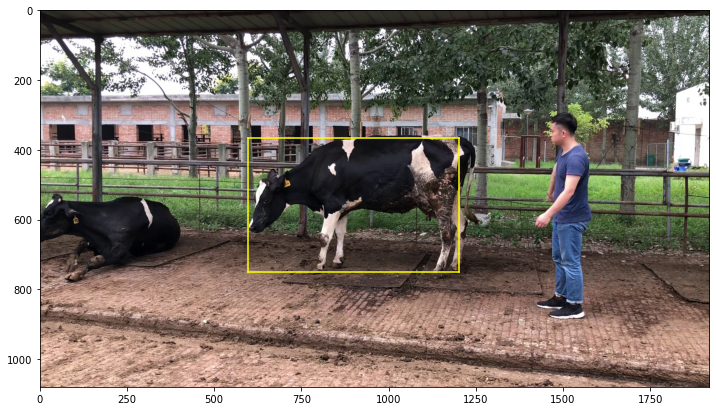

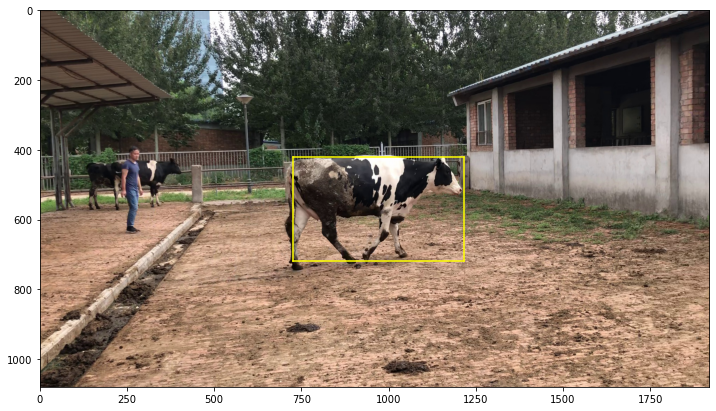

In [8]:
for i in range(41, 45):
    plot_image(format_image_id(i), plot_box=True)

# Extremes
- Lets find extreme values of bounding boxes across all images, to facilitate augmentation

In [9]:
min_x, min_y, max_x, max_y = float('inf'), float('inf'), float('-inf'), float('-inf')
for i in tqdm(range(1, MAX_IMAGE_ID+1)):
    if i not in MISSING_IMAGES:
        box_i = get_box(parse_annotations(os.path.join(ANNOTATION_PATH, format_image_id(i)+'.txt')))
        min_x = min(min_x, box_i[0])
        min_y = min(min_y, box_i[1])
        max_x = max(max_x, box_i[2])
        max_y = max(max_y, box_i[3])
print('Horizonal extremes are X = [{}, {}]/{}'.format(min_x, max_x, IMAGE_SIZE[1]))
print('Vertical extremes are Y = [{}, {}]/{}'.format(min_y, max_y, IMAGE_SIZE[0]))

100%|████████████████████████████████████████████████████████████████████████████| 2213/2213 [00:00<00:00, 5017.66it/s]

Horizonal extremes are X = [159.0, 1713.0]/1920
Vertical extremes are Y = [145.0, 971.0]/1080


>Based on the extremes there is not enough margin to perform crop and rotation operation on all images while preserving all key points. we will loose some key-point references while performing augmentations(if necessary), so we must keep labeling information we extracted earlier.